# APS1070
#### Lab 2 - Anomaly Detection Algorithm using Gaussian Mixture Model 
**Deadline: Feb 14, 23:59 - 10 points**

Please fill out the following:


*   Name: __Vijaykumar Maraviya__
*   Student Number __1006040320__ 

## **Marking Scheme:**

This project is worth **10 marks** of your final grade.

**One (1) mark** of the lab is dedicated to **vectorized coding**. If you need to write a loop in your solution, think about how you can implement the same functionality with vectorized operations. Try to avoid loops as much as possible (in some cases loops are inevitable).

This notebook is composed of two sections, a Tutorial, and an Exercise. 

The TAs in the lab will help you to complete your tutorial (Although no mark is assigned to the **tutorial** compeleting that section is **mandatory**). 

**The exercise** section is worth **9 points**.

## **Important Note:**

1] Please **write answers** for the Tutorial & Exercise in the **blanks provided**.

2] Start lab early so that you understand concepts in Tutorial well & get enough time to implement exercise  

3] It is important to **complete and run the tutorial part** of the notebook. Make sure you complete both, tutorial as well as exercise part.
 
4] Provide a graphical representation of data wherever necessary.  


## Tutorial

In this part of the assignment, we will implement an anomaly detection algorithm using the Gaussian model to detect anomalous behavior in a 2D dataset first and then a high-dimensional dataset.

Loading relevant libraries and the dataset

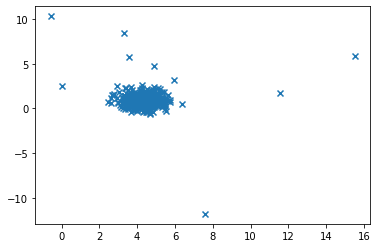

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=1,
                       cluster_std=0.60, random_state=0)
X_append, y_true_append = make_blobs(n_samples=10,centers=1,
                                    cluster_std=5,random_state=0)
X = np.vstack([X,X_append])
y_true = np.hstack([y_true, [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting
plt.scatter(X[:,0],X[:,1],marker="x");

Here we've manufactured a dataset where some points are visibly outliers from the main distribution.

We can see this from looking at the plot, but how do we robustly identify the outliers? 

That's where a Gaussian estimation comes in. For this dataset, we only need a single Gaussian, for which we are gonna calculate the mean and standard deviation. Then, we're able to find the points that don't seem likely to have originated from that distribution - these are our outliers!

First, we need to calculate the mean and variance for our data. Complete the function below to generate these values using these formulas:

$$\mu = \frac{1}{m} \sum_{i=1}^{m}X_i$$

$$\sigma^2 = \frac{1}{m} \sum_{i=1}^{m}(X_i-\mu)^2$$

In [5]:
def estimateGaussian(X):
    """
     This function estimates the parameters of a Gaussian distribution using the data in X
    """
    m = X.shape[0]
    
    #compute mean of X
    sum_ = X.sum(axis = 0)
    mu = X.mean(axis = 0)
       
    # compute variance of X
    var = np.var(X, axis = 0)
    
    return mu,var

mu, sigma2 = estimateGaussian(X)

Now, we will calculate for each point in X, the probability of the distribution $N(\mu,\sigma^2)$ generating that point randomly. This has been completed for you, although it is important to understand how the calculation of the PDF works.

In [7]:
def multivariateGaussian(X, mu, sigma2):
    """
    Computes the probability density function of the multivariate gaussian distribution.
    """
    k = len(mu)
    
    sigma2=np.diag(sigma2)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma2)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma2) * X,axis=1))
    
    return p

p = multivariateGaussian(X, mu, sigma2)

Now that we have the probability of each point in the dataset, we can plot these on the original scatterplot:

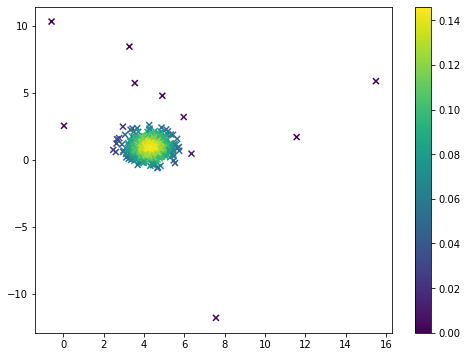

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
plt.colorbar();

We're getting closer to the point where we can programmatically  identify our outliers for a single Gaussian distribution. The last step is to identify a value for $p$, below which we consider a point to be an outlier. We term this $\epsilon$.

In [10]:
#Choose a value for epsilon

epsilon = 0.02

Now we'll highlight on the scatter plot all points that are below $\epsilon$:

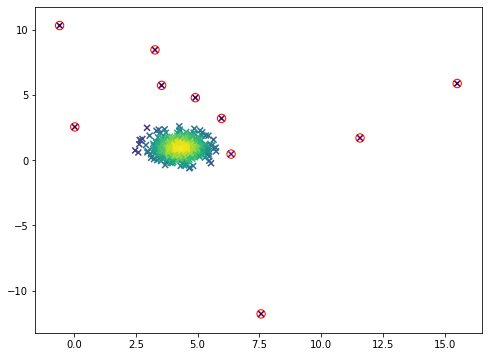

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');

# Circling of anomalies
outliers = np.nonzero(p<epsilon)[0]
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);

What value of epsilon did you choose? Why? __$\epsilon$ = 0.02. Because this $\epsilon$ value as thresold seems to correclty identify the outliers in above model.__

Play around with different values until you're happy with the plot above. 

We can additionally look at our model's classification performance another way. By sorting the points ascending by their probability, and classifying the first $k$ points as anomalous, we can determine the model's precision@k. Implement this in the cell below. 

* What is the highest value of K for which we get a precision of 1.0? __10__
* What is the precision for K=4? __1.0__

In [16]:
from sklearn.metrics import precision_score

for i in range(0,15):
    mn = sorted(p)[i]
    sc = precision_score(y_true, p<=mn)
    print(i+1,sc)

1 1.0
2 1.0
3 1.0
4 1.0
5 1.0
6 1.0
7 1.0
8 1.0
9 1.0
10 1.0
11 0.9090909090909091
12 0.8333333333333334
13 0.7692307692307693
14 0.7142857142857143
15 0.6666666666666666


You may have noticed that in this example, we are training and testing on the _entire_ dataset. This is absolutely not standard practice! You should _always_ split into a training and testing set. However, the reason that we can get away with this here is that we don't actually use labels at all during training - this is an _unsupervised_ machine learning task. Unsupervised learning methods are beneficial for anomaly detection because in the real world (i.e. testing!) we might come across types of outliers that we didn't see during training. We want to use a method that can handle this, and unsupervised methods are often better suited to this type of domain.

For the next section, we'll move to a Mixture of Gaussian models. Take a look at the following dataset:

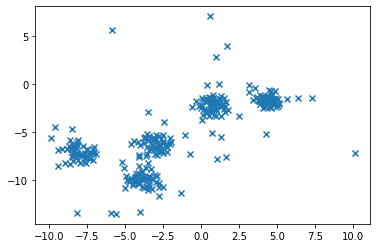

In [17]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
X, y_true = make_blobs(n_samples=400, centers=5,
                       cluster_std=0.60, random_state=1)
X_append, y_true_append = make_blobs(n_samples=50,centers=5,
                                    cluster_std=5,random_state=1)
X = np.vstack([X,X_append])
y_true = np.hstack([[0 for _ in y_true], [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting

X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.33, random_state=1, shuffle=True)

plt.scatter(X_train[:,0],X_train[:,1],marker="x");

Okay, we have more than one cluster centre now. So what? Let's just ignore that and use the same model as before. 

* What is the precision for k=1 in the cell below? __1.0__
* k=10? __0.9__
* k=100? __0.13__

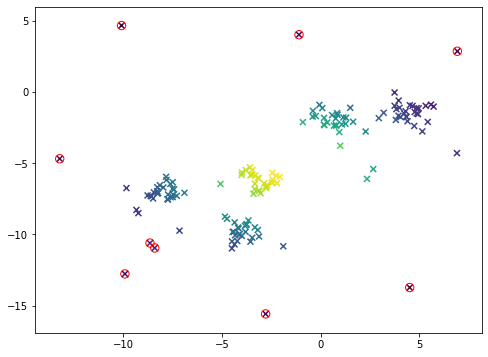

In [18]:
mu, sigma2 = estimateGaussian(X_train)
p = multivariateGaussian(X_test, mu, sigma2)
plt.figure(figsize=(8,6))
plt.scatter(X_test[:,0],X_test[:,1],marker="x",c=p,cmap='viridis');
outliers = np.nonzero(p<0.001)[0]
plt.scatter(X_test[outliers,0],X_test[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);


In [19]:
for i in range(0,149):
    mn = sorted(p)[i]
    sc = precision_score(y_test, p<=mn)
    if i in [0,9,99]:
        print(i+1,sc)

1 1.0
10 0.9
100 0.13


Uh oh. This model performs terribly. It's fit the mean to a section of space where we don't have _any_ points, and it has absolutely no idea which points are outliers! This was probably pretty obvious to you though. We need to move to a Mixture of Gaussians model - one in which we use multiple Gaussians to fit the data. We'll use `sklearn.mixture.GaussianMixture` to do this - or rather you will! Use the documentation, found [here](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) to initialise and fit a `GaussianMixture` object called `gm` in the cell below.

In [20]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components = 5,
                    covariance_type = 'full', random_state=0, )
gm.fit(X_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Now we can use the method `gm.score_samples()` which gives a score based on how likely a point is to have been generated by any cluster:

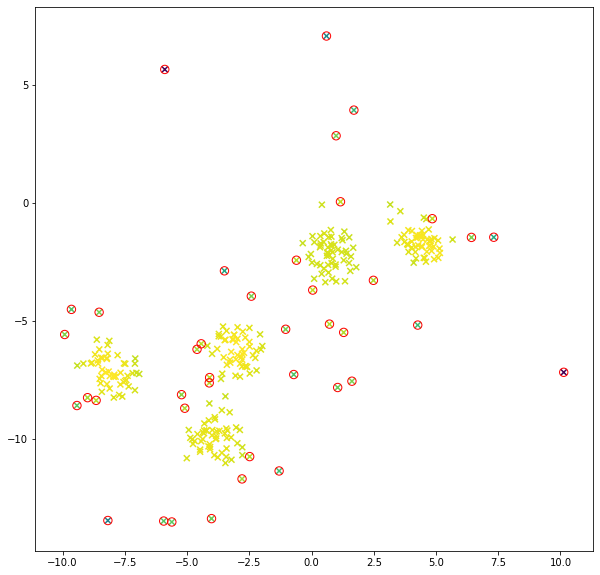

In [23]:
plt.figure(figsize=(10,10))
c = gm.score_samples(X_train)
plt.scatter(X_train[:,0],X_train[:,1],c=gm.score_samples(X_train),cmap='viridis',marker='x')

threshold= -4.8

outliers = np.nonzero(c<threshold)[0]
plt.scatter(X_train[outliers,0],X_train[outliers,1],marker="o",facecolor= "none",edgecolor="r",s=70);

What is the variable "`threshold`"? __It is the value below which the sample is classified as a outlier.__ Why is it negative? __The `score_samples` computes the weighted log probabilities for each sample. Probability values are between 0 and 1, and log of a value less than one gives a negative number. Hence, threshold also need to be defined as a negetive number.__
 
Now we can use the method `gm.predict_proba()` to spot the points in each of the clusters.

In [32]:
Non_Outliers=np.nonzero(c>=threshold)[0]
X_t=X_train[Non_Outliers]


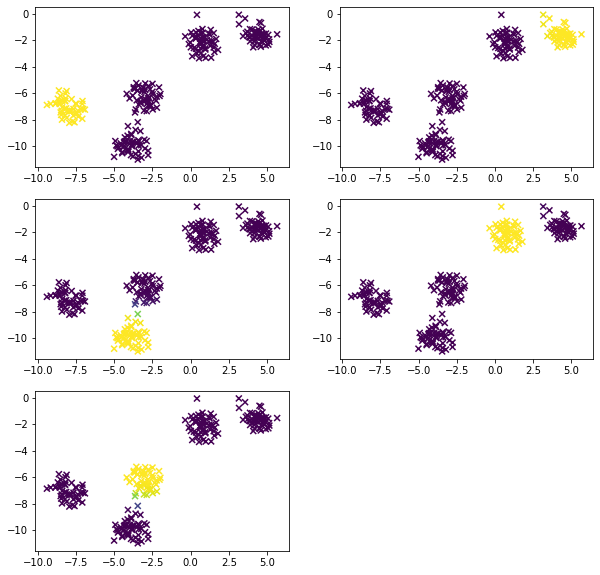

In [33]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(3,2,i+1)
    plt.scatter(X_t[:,0],X_t[:,1],c=gm.predict_proba(X_t)[:,i],cmap='viridis',marker='x')

1] What do functions `gm.score_samples()` and `gm.predict_proba()` return? __`gm.score_samples()`: the weighted log probabilities for each sample. `gm.predict_proba()`: posterior probability of each component given the data__

2] Why it was important to run them in above sequence? __First, we used `score_samples` to identify the outliers.Then, we used `predict_proba` to identify the assignment of a given sample to the cluster it belongs using color coding while ploting.__ 

3] What is the difference between the two function? __`score_samples` returns the log of the sum of sample's probability under each of the components, multiplied by the weight of each component, whereas `predict_proba` returns  a matrix of size [n_samples, n_clusters] which measures the probability that any point belongs to the given cluster.__ 

Our Mixture of Gaussians model is powerful! Not only is it unsupervised, it can both classify points into one of the K clusters we have, _and_ it can help us with our ultimate goal of identifying outlier points! We can do this by finding the points that no cluster wants to claim for itself.

In the cell below, complete the code and calculate these values and then compute precision@k for k=1, 10, and 100. The ROC curve code has been completed for you. 

* Is this model better or worse performing than the previous? __better__
* Why might that be? __From precision and recall, it is clear that this model is performing better. This is because we have identfied the clusters and fitted our gaussians to clusters. The ROC curves also show the same as the AUC (area under curve) for gaussian mixture is greater than that for single component model.__

for a K of 1 the precision is 1.000000 and the recall is 0.111111
for a K of 10 the precision is 1.000000 and the recall is 0.611111
for a K of 100 the precision is 0.178218 and the recall is 1.000000


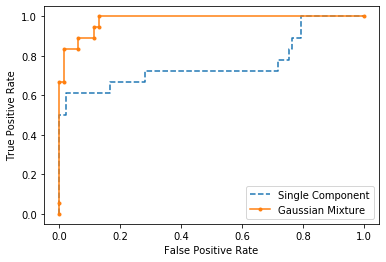

In [35]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#This part outputs the precision and recall on the test set

#score_samples will compute the weighted log probabilities for each sample
p_gm = gm.score_samples(X_test) 

#Complete code below
for i in [1,10,100]: 
   #sort the points by probability, as before
   mn_gm = sorted(p_gm)[i]
   #compare y_test labels to our picks using precision
   precision = precision_score(y_test,p_gm<=mn_gm)
   #compare y_test labels to our picks using recall
   recall = recall_score(y_test, p_gm<=mn_gm) 
   #print precision and recall three times
   print('for a K of',i, 'the precision is','%3f' %precision,'and the recall is', '%3f' %recall)

#This part computes the ROC curves for both models like we talked about in class

from sklearn.metrics import roc_curve
from matplotlib import pyplot
fpr_sc, tpr_sc, _ = roc_curve(y_test, 1-p)
fpr_gm, tpr_gm, _ = roc_curve(y_test, 1-p_gm)
pyplot.plot(fpr_sc, tpr_sc, linestyle = '--', label='Single Component')
pyplot.plot(fpr_gm, tpr_gm, marker='.', label='Gaussian Mixture')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend();


Let's look at a dataset that motivates using a Mixture of Gaussians model: Simpsons ratings.

Everyone knows that there's a certain point when The Simpsons "got bad", but can we use a Mixture of Gaussians to find out exactly when that was?

Load up the `simpsons.pickle` file using the cell below. It contains the IMDb rating for every simpsons episode.

In [37]:
#!wget https://github.com/alexwolson/APS1070_data/raw/master/simpsons.pickle
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
with open('simpsons.pickle','rb') as f:
    simpsons = pickle.load(f)

Plot a histogram of the rating distribution for all Simpsons episodes. 

 What is the modal rating? __7.1__
* What is the range of ratings? __(4.0, 9.3)__

minimum value = 4.0, maximum value = 9.3, mode = 7.1


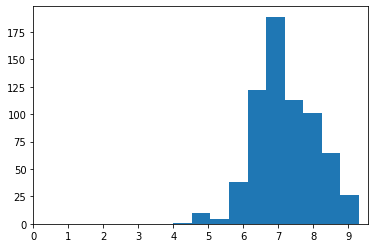

In [38]:
import statistics
rating = []
for key, value in sorted(simpsons.items()):
    for key2, value2 in value.items():
        rating.append(value2)

print('minimum value = {}, maximum value = {}, mode = {}'.format(min(rating), max(rating), statistics.mode(rating)))

import matplotlib.pyplot as plt
plt.hist(rating, bins = 10)
plt.xticks(range(10))
plt.show()

Next, use Gaussian Mixture to fit a Mixture of Gaussians to the Simpsons rating distribution. Since we are trying to distinguish between good and bad ratings, we only need 2 gaussians.

* What are the means for the two Gaussians fit by the model? __6.773 and 8.179__
* What about the standard deviations? __0.597 and 0.474__

Mean of the models are [[6.7734211 ]
 [8.17942889]]
standard deviations are [[[0.59689303]]

 [[0.4741226 ]]]


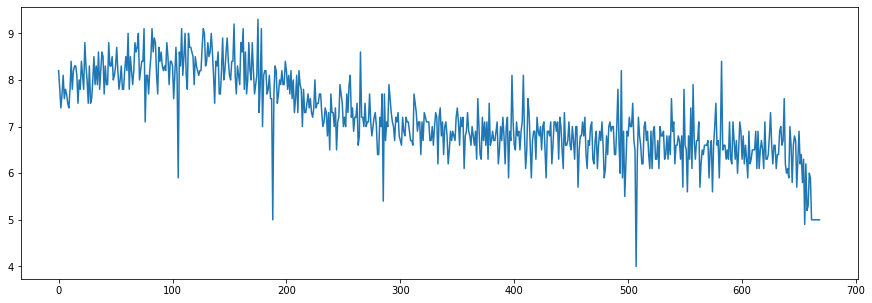

In [43]:
rating = np.array(rating)
gm1 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
gm1.fit(rating.reshape(-1, 1))

plt.figure(figsize=(15,5))
plt.plot(rating);

print('Mean of the models are', format(gm1.means_))
print('standard deviations are', format(np.sqrt(gm1.covariances_)))

Finally, using the `GuassianMixture.predict()` method, we can use maximum likelihood to estimate which distribution, good or bad, each episode belongs to. In the cell below, we have provided code to count the number of episodes predicted to be in the "good" distribution per season, and plot for the same.
Understand the code and answer the question.

* Where is the notable drop-off point? __After 9th season__
* What is the first season with 0 good episodes? __Season 15__


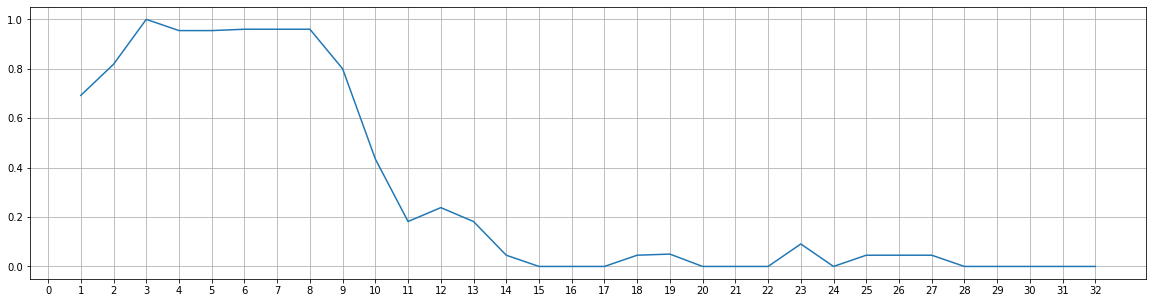

In [45]:
#Let's first associate each component with a good or bad season
if gm1.means_[0,0] > gm1.means_[1,0]: #True if first component is the good season (ie, higher mean)
     Good_season_index = 0
else:
     Good_season_index = 1

Xs = []
Ys = []
simpsons = dict(sorted(list(simpsons.items()), key=lambda x: x[0]))
for season, episodes in simpsons.items():
     bad = 0
     good = 0
     for episode in episodes.values():
          if gm1.predict(np.array(
               episode
          ).reshape(-1,1)) == Good_season_index:
               good += 1
          else:
               bad += 1
     Xs.append(season)
     Ys.append(good/(good+bad))
plt.figure(figsize = (20,5))
plt.plot(Xs,Ys);
plt.xticks(range(33))
plt.grid()

## Exercises

Now we are going to work with a credit card fraud dataset (more detail can be found [here](https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcardfraud.zip/3)). This dataset contains 28 key features, which are not 
directly interpretable but contain meaningful information about the dataset.

Load up the dataset in CSV file using Pandas. The dataset is called `creditcard.csv`. Print out the first few columns of the dataset.

* How many rows are there?[0.5] __284807__
* What features in the dataset are present aside from the 28 main features?[0.5]  __Time and Amount__
* Why do you think the main features are given to us in this way?[0.5] __There may be concerns regarding privacy or security due to sensitive information.__
* Which column contains the targets? Can you figure out what the values correspond to?[0.5] __column 'Class' contains the targets. Vaues are 0 (not fraud) and 1 (fraud)__ 

In [46]:
pip install wget

Note: you may need to restart the kernel to use updated packages.


In [47]:
import wget

wget.download('https://github.com/alexwolson/APS1070_data/raw/master/creditcard.tar.gz','creditcard.tar.gz')

100% [.......................................................] 68750473 / 68750473

'creditcard.tar.gz'

In [48]:
!tar -zxvf creditcard.tar.gz

x creditcard.csv


In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('creditcard.csv')
print(df.shape)
print(df['Class'].unique())
df.head()

(284807, 31)
[0 1]


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


It's always important when looking at a new dataset to figure out how many rows we have for each class.

* What is the percentage of entries in the dataset for each class?[0.5] __class 0: 99.83% and class 1: 0.17%__

* Is this target data balanced or unbalanced? why do you think this is so?[0.5] __Target data is unbalanced. This is because the number of fraud transactions is significantly less compared to genuine transactions.__ 

* Why might this pose a problem when methods we have looked at so far?[1] __The methods we have looked at so far such as KNN, Decision tree, and so on depends on large number of both postive and negative data for learning. Also, the metrices used to measure model performance would not work. For instance, even if the model predict negative result (not fraud) for all the samples in the test dataset, the accuracy of the model will be very high. (99.83% in this case)__



In [60]:
class0 = df[df['Class'] == 0]
class1 = df[df['Class'] == 1]
print(print('% of entries in class0 is {} \n% of entries in class1 is {}'.format((len(class0)/len(df)), (len(class1)/len(df)))))

% of entries in class0 is 0.9982725143693799 
% of entries in class1 is 0.001727485630620034
None


Next, split the dataset into a training and testing set. Use a test size of one third, and set the random state to 0.

Make sure to separate out the column corresponding to the targets.

As mentioned earlier, in this lab we are going to use Gaussian distributions to model the data. To accomplish this, we are going to introduce `scipy`, a package which contains a wide variety of tools for working with scientific data in Python. Its `stats` package allows us to easily model various statistical distributions, and get information about them.

Scipy's Gaussian distribution class is called `norm`. It takes two parameters - `loc`, which corresponds to the mean of your distribution, and `scale`, which corresponds to the standard deviation.

* What are the mean and standard deviation for variable V24? Make sure to only use your training set for this. [1]  __mean = 0.0004296 and Standard deviation = 0.604829__

Use the code below to set up a Gaussian object for V24.

In [63]:
from scipy import stats

target_data = df['Class']
target_data = pd.DataFrame(target_data, columns = ['Class'])
feature_data = df.drop(['Class'], axis= 1)

#spilt the data
X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size = 1/3, random_state = 0)

mean24 = X_train['V24'].mean()
std24 = X_train['V24'].std()

print('mean is {}, standard deviation is {}' .format(mean24, std24))

from scipy import stats

norm = stats.norm(mean24, std24)


mean is 0.00042967016116414686, standard deviation is 0.6048294388274841


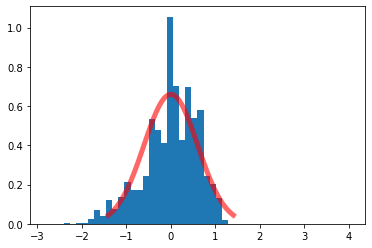

In [64]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
ax.hist(X_train['V24'].values, density=True, histtype='stepfilled', bins=50);
plt.show()

We can also look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

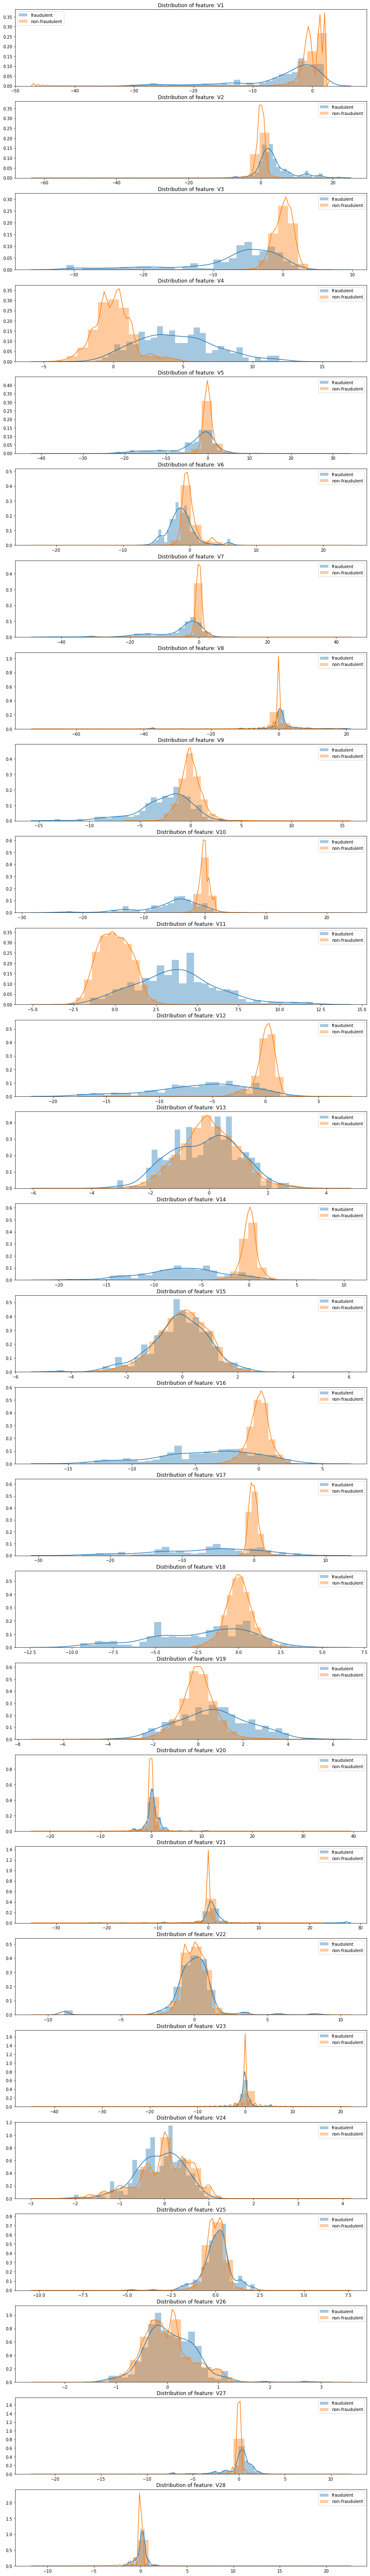

In [66]:
import matplotlib.gridspec as gridspec
import seaborn as sns
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(X_train[feat][y_train['Class'] == 1], bins=30)
    sns.distplot(X_train[feat][y_train['Class'] == 0],bins=30)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

1] Build an outlier detection model using a Mixture of Gaussians using five features with a large difference in distribution between fraudulent and non-fraudulent data. Report the precision and recall @k for k=1, 10 and 100 (on test data). Repeat this model creation process, this time selecting five features with a of your own choice, and reporting the precision and recall as above. [2] __The precision and recall is reported for five different models below.__

2] What features did you choose for each model? What effect it had on the model performance? [1] 

__I visually identifed the feraures with less overlap and high overlap. First, for the first three models, I used features with less overlap and changed the model parameters such as numebr of components. The model's precision and recall decreased with increase in number of components.__

__Then I used features with high overlap for last two models. As expected, the precision and recall decreased compare to first three models.__

3] Organize your findings in a table or plot and describe your findings. What can you conclude about what models work best?[1] __find the graph and summary below.__

In [ ]:
def outlierDetect(X, components):
    X_train, X_test, y_train, y_test = train_test_split(X, target_data, test_size = 1/3, random_state = 0)

    GM = GaussianMixture(n_components = components, covariance_type= 'full', random_state=0)
    GM.fit(X_train)
    P = GM.score_samples(X_test)

    recall_scores = []
    req_p_scores = []
    req_r_scores = []
    for i in range(100):
        sortP = sorted(P)[i]
        precision = precision_score(y_test, P <= sortP)
        recall = recall_score(y_test, P <= sortP)

        if i == 0 or i==9 or i==99:
            print('For a K of ', i+1, ', the precision is ', '%.3f' % precision, 'and the recall is ', '%.3f' % recall)
            req_p_scores.append(precision)
            req_r_scores.append(recall)

        recall_scores.append(recall)

    FPR, TPR, _ = roc_curve(y_test, 1-P)

    #plot recall rate for various values of K and ROC curve

    fig, (pl1, pl2) = pyplot.subplots(1, 2, figsize = (10,6))
    pl1.plot(recall_scores)
    pl1.set_xlabel('K')
    pl1.set_ylabel('Recall rate')
    pl1.set_title('Recall rate vs K')
    pl1.grid()

    pl2.plot(FPR, TPR, marker = '.', label = 'Gaussian Mixture')
    pl2.set_xlabel('false positive rate')
    pl2.set_ylabel('true postive rate')
    pl2.set_title('ROC')
    pl2.grid()

    pyplot.legend()
    pyplot.show()

    return (req_p_scores, req_r_scores)

For a K of  1 , the precision is  0.000 and the recall is  0.000
For a K of  10 , the precision is  0.900 and the recall is  0.055
For a K of  100 , the precision is  0.610 and the recall is  0.372


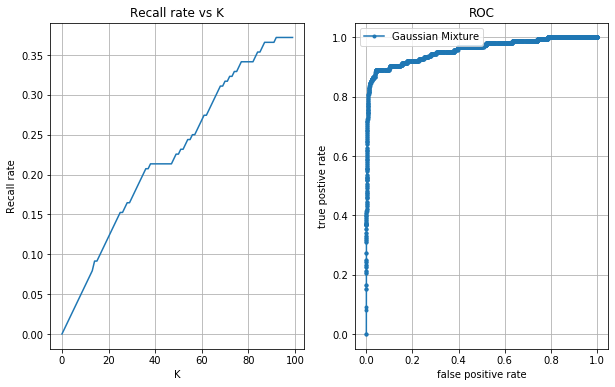

In [99]:
model1_P, model1_r = outlierDetect(feature_data[['V3', 'V4', 'V10', 'V13', 'V14']], 1)

For a K of  1 , the precision is  0.000 and the recall is  0.000
For a K of  10 , the precision is  0.700 and the recall is  0.043
For a K of  100 , the precision is  0.520 and the recall is  0.317


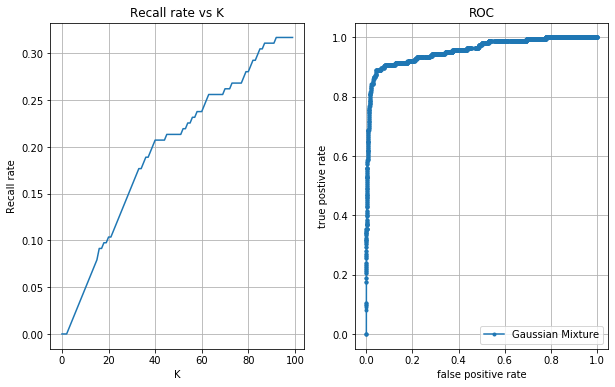

In [100]:
model2_P, model2_r = outlierDetect(feature_data[['V3', 'V4', 'V10', 'V13', 'V14']], 2)

For a K of  1 , the precision is  0.000 and the recall is  0.000
For a K of  10 , the precision is  0.700 and the recall is  0.043
For a K of  100 , the precision is  0.540 and the recall is  0.329


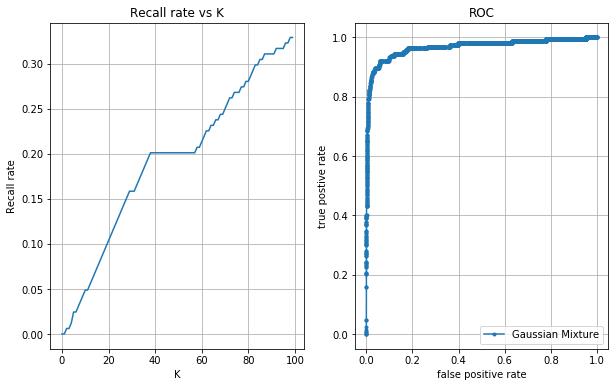

In [101]:
model3_P, model3_r = outlierDetect(feature_data[['V7', 'V4', 'V10', 'V16', 'V14']], 3)

For a K of  1 , the precision is  0.000 and the recall is  0.000
For a K of  10 , the precision is  0.000 and the recall is  0.000
For a K of  100 , the precision is  0.000 and the recall is  0.000


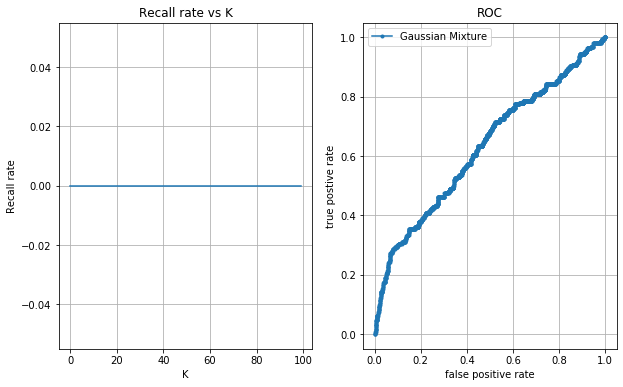

In [102]:
model4_P, model4_r = outlierDetect(feature_data[['V25', 'V20', 'V22', 'V23', 'V24']], 1)

For a K of  1 , the precision is  0.000 and the recall is  0.000
For a K of  10 , the precision is  0.200 and the recall is  0.012
For a K of  100 , the precision is  0.390 and the recall is  0.238


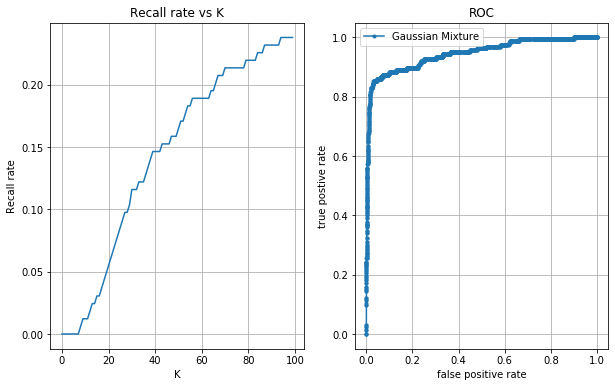

In [103]:
model5_P, model5_r = outlierDetect(feature_data[['V1', 'V5', 'V9', 'V14', 'V15']], 2)

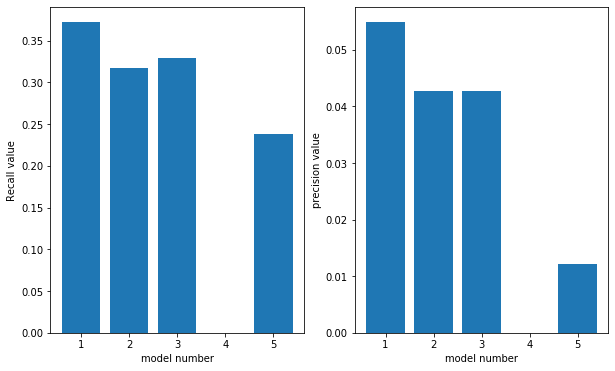

In [111]:
models = [1,2,3,4,5]
recall_values = [model1_r[2], model2_r[2], model3_r[2], model4_r[2], model5_r[2]]
precision_values = [model1_r[1], model2_r[1], model3_r[1], model4_r[1], model5_r[1]]

fig, (pl1, pl2) = pyplot.subplots(1, 2, figsize = (10,6))
pl1.bar(models, recall_values)
pl1.set_xlabel('model number')
pl1.set_ylabel('Recall value')


pl2.bar(models, precision_values)
pl2.set_xlabel('model number')
pl2.set_ylabel('precision value')

plt.show()



## Summary:

__1) The features with less overlap produce good performance metrices. (recall, precision). It is evident from above bar graph. For model 4 and 5, the features with large overlap are selected, which resulted in lower recall and precision.__

__2) For this data set, as the number of components increased, the recall and precision is reduced.__

__3) With increse in K, the recall increases, whereas the precision decreases.__ 
